#Your turn now!

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from skimage import io
import os
import sys
from astropy.io import fits
import pandas as pd
from scipy import interpolate
import sys

#Load and visualise ITO data

In [2]:
! git clone https://github.com/magnushandley/MIGDAL3dreconstruction.git
! git pull

Cloning into 'MIGDAL3dreconstruction'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 32 (delta 12), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (32/32), done.
fatal: not a git repository (or any of the parent directories): .git


In [3]:
itofilepath = "/content/MIGDAL3dreconstruction/Ar0634_event618.npy"
deconvolvedimg = "/content/MIGDAL3dreconstruction/ar_0634_img0306.tif"
rawnodark = "/content/MIGDAL3dreconstruction/ar_0634_img0306nodark.tif"

#Load ITO pulse
Reminder of the format of the ITO pulses here - this is a 3D numpy array (bit different to before), where the 1st index specifies the strip number, 2nd whether you want daq time (index 0) or voltage (index 1), and 3rd the actual sample. 

This is done by the 'displaygivenevent' function in the ITOstripcore.py file extracted from the github if you want inspiration.

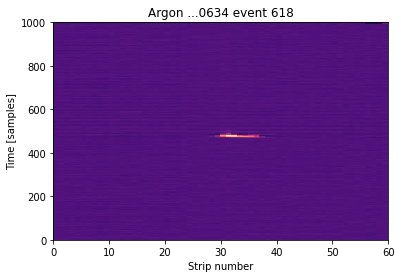

In [4]:
data = np.load(itofilepath)

def displaygivenevent(data):
        """
        Displays an event passed to this function, rather than from the main 'data' array. Used if you aren't using the class in quite the normal way.
        """
        eventdata = np.zeros((60,1000))
        for i in range(60):
            eventdata[i] = data[i][1]
            offsetmean = np.mean(eventdata[i][:200])
            eventdata[i] = np.subtract(eventdata[i], offsetmean)
        plt.pcolormesh(eventdata.T, cmap='magma')
        plt.xlabel("Strip number")
        plt.ylabel("Time [samples]")
        plt.title("Argon ...0634 event 618")

displaygivenevent(data)

#Load and view image

I have preloaded a version of this image with some processing, but if you would like to deconvolute and subtract the dark yourselves (please do!) this is image:

MIG_full_readout_Fe55_Ar_CF4_220805T150634.CAL.0306.TIFF

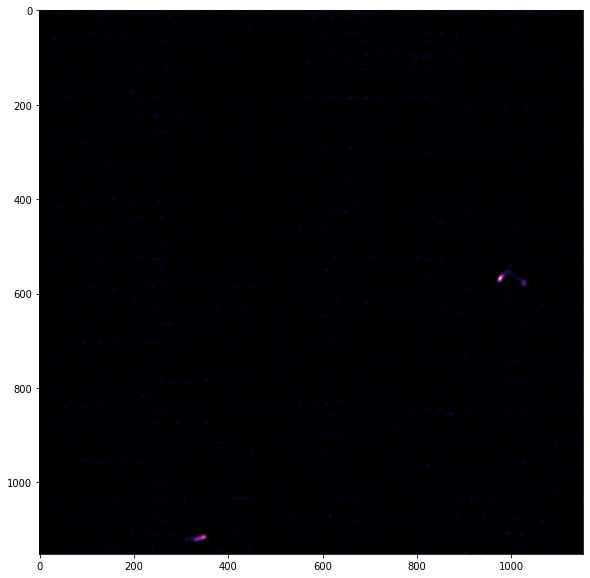

In [5]:
img = io.imread(deconvolvedimg)

fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(img, cmap="magma")

#Running the ridgefinder

In the interests of making life easier, have supplied the ridgefinder code in two functions from RFsingletiff - 

singletiff(pathname,sigma, lt, ut, minlen, linkthresh, logim = False) will display the image, ridges and basic bragg curves (from the deconvoluted image, not what we want to do for actual analysis)

returnlines(pathname,sigma, lt, ut, minlen, linkthresh, logim = False) returns x and y coordinate arrays containing the points. These are actual x and y coordinates which do not need to be reversed.

-2.975289567577019
1.4015572553645315


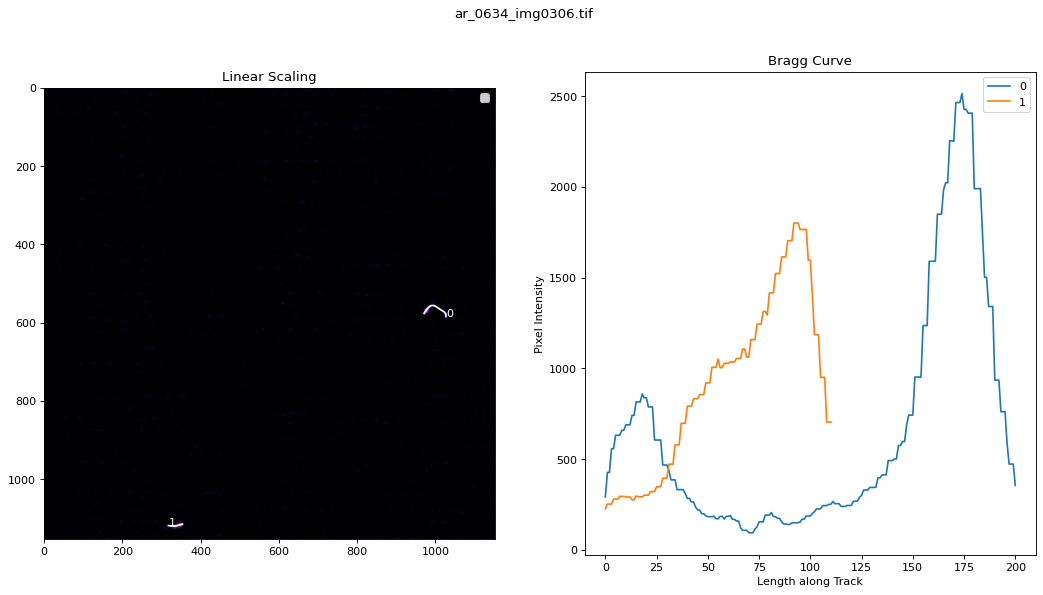

In [6]:
sys.path.insert(0, '/content/MIGDAL3dreconstruction/')
from RFsingletiffws import *

SIGMA = 2.5 #sigma for derivative determination ~> Related to track width
lthresh = 10 #tracks with a response lower than this are rejected (0 accepts all)
uthresh = 0 #tracks with a response higher than this are rejected (0 accepts all)
minlen = 12 #minimum track length accepted
linkthresh = 40 #maximum distance to be linked
logim = False

singletiff(deconvolvedimg,
    SIGMA,
    lthresh,
    uthresh,
    minlen,
    linkthresh,
    logim)

x,y = returnlines(deconvolvedimg,
    SIGMA,
    lthresh,
    uthresh,
    minlen,
    linkthresh,
    logim)

#Integrate ITO strips

Text(0, 0.5, 'Charge deposited to strip [Au]')

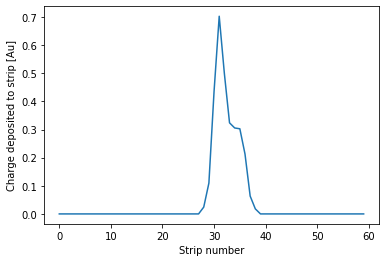

In [7]:
def stripintegrals(eventdata):
        """
        Inputs
        --------
        eventdata: 3d numpy array, indexing - 1st specifies the strip and 2nd the sample number
        
        Outputs:
        ---------
        rowintegrals: returns the energy deposition on each strip, as a numpy array
        """
        rowintegrals = np.zeros(60)
        
        for i in range(60):
            rowdata = eventdata[i][1]
            offsetmean = np.mean(rowdata[:200])
            std = np.std(rowdata[:200])
            rowdata = np.subtract(rowdata, offsetmean)
            max = np.amax(rowdata)
            maxindex = int(np.where(rowdata == max)[0][0])
            
            #finds the points at which the signal drops below zero
            startfound = False
            j = maxindex
            
            while ((startfound == False) and (j >= 0)):
                if rowdata[j] <= 0:
                    startpoint = j
                    startfound = True
                else:
                    j -= 1
              
            endfound = False
            k = maxindex
            while ((endfound == False) and (k<1000)):
                if rowdata[k] <= 0:
                    endpoint = k
                    endfound = True
                else:
                    k += 1
              
            if (max > 5*std):
                integral = np.sum(rowdata[startpoint:endpoint])
                rowintegrals[i] = integral
            else:
                rowintegrals[i] = 0
            
        return(rowintegrals)

charge = stripintegrals(data)
plt.plot(charge)
plt.xlabel("Strip number")
plt.ylabel("Charge deposited to strip [Au]")

#3D reconstruction - mean position

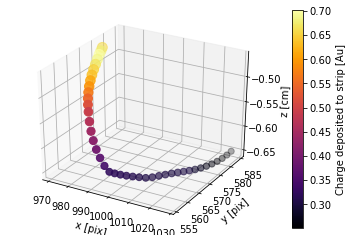

In [8]:
offset = 2
driftvel = 13

def peaktime(eventdata):
        """
        Returns the sample number at which each ITO strip is at a maximum
        """
        maximums = np.zeros(60)
        maxtimes = np.zeros(60)
        
        for i in range(60):
            max = np.amax(eventdata[i][1])
            maximums[i] = max
            index = int(np.where(eventdata[i][1] == max)[0][0])
            maxtimes[i] = eventdata[i][0][index]
            
        return(maxtimes)

def pixeltostrip(pixel, offset):
    """
    Takes the x coordinates of all points along the ridge and returns the coordinates in strips
    """
    strip = np.add(0.084375*pixel, (10.89996 - offset))
    return(strip)

#taking every ::nth value, the splicing from the ridgefinder gives an almost continuous curve,
#this kind of granularity isn't really required for what we're doing here.
x = x[::5]
y = y[::5]

trackstrip = pixeltostrip(x,offset)

peaks = np.zeros(120)
halfpeaks = peaktime(data)
peaks[:60] = halfpeaks
peaks[60:] = halfpeaks

stripdep = np.zeros(120)

#we already calculated the charge deposited to each strip earlier
stripdep[:60] = charge
stripdep[60:] = charge
stripdepinterp = interpolate.interp1d(np.arange(120),stripdep)
deposition = stripdepinterp(trackstrip)
        
interpolatedpeaks = interpolate.interp1d(np.arange(120), peaks)

deltaz = np.zeros(len(x))

for i in range(len(trackstrip)):
    deltaz[i] = interpolatedpeaks(trackstrip[i])*driftvel

fig = plt.figure()
ax = plt.axes(projection='3d')
scatter_plot = ax.scatter3D(x,y,deltaz,c=deposition,s=deposition*150,cmap='inferno')

ax.set_xlabel("x [pix]")
ax.set_ylabel("y [pix]")
ax.set_zlabel("z [cm]")
#ax.set_zlim(-0.8,-0.4)
#ax.set_xlim(220,320)
#ax.set_ylim(540,600)

plt.colorbar(scatter_plot, label="Charge deposited to strip [Au]")
plt.show()